## Part 3 - Model Selection and Optimization

In [0]:
# !pip install tensorflow==1.14.0

In [1]:
# Mounting the drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
# Change the current working Directory 
import os

path = '/content/drive/My Drive/Project/NLP'
try:   
    os.chdir(path)
    print("Directory changed to Project folder")
except OSError:
    print("Can't change the Current Working Directory")  

Directory changed to Project folder


In [3]:
# Import necessary items
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Flatten, Bidirectional, GlobalMaxPool1D, SpatialDropout1D, TimeDistributed
from tensorflow.keras.models import Model, Sequential
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn import metrics

Using TensorFlow backend.


In [0]:
# Load dataframe from pickled pandas object. This is the english data
processedEnglishData= pd.read_pickle('processedEnglishData.pkl')

In [0]:
processedEnglishData.head()

,Caller,Combined description,Assignment group
0,spxjnwir pjlcoqds,login issue verify user detailsemployee manage...,GRP_0
1,hmjdrvpb komuaywn,outlook hmjdrvpb komuaywn gmail team meetingss...,GRP_0
2,eylqgodm ybqkwiam,not log vpn eylqgodm ybqkwiam gmail not log vp...,GRP_0
3,xbkucsvz gcpydteq,unable access hrtool page unable access hrtool...,GRP_0
4,owlgqjme qhcozdfx,skype error skype error,GRP_0


In [0]:
processedEnglishData.shape

(7672, 3)

In [0]:
glove_file = path + "/Data/glove.6B.zip"

In [0]:
#Extract Glove embedding zip file
from zipfile import ZipFile
with ZipFile(glove_file, 'r') as z:
  z.extractall()

In [0]:
# Including a len column to find the maximum length of each cell
processedEnglishData['len'] = processedEnglishData['Combined description'].apply(lambda x: len(x.split(" ")))
processedEnglishData.head()

,Caller,Combined description,Assignment group,len
0,spxjnwir pjlcoqds,login issue verify user detailsemployee manage...,GRP_0,22
1,hmjdrvpb komuaywn,outlook hmjdrvpb komuaywn gmail team meetingss...,GRP_0,16
2,eylqgodm ybqkwiam,not log vpn eylqgodm ybqkwiam gmail not log vp...,GRP_0,10
3,xbkucsvz gcpydteq,unable access hrtool page unable access hrtool...,GRP_0,8
4,owlgqjme qhcozdfx,skype error skype error,GRP_0,4


In [0]:
maxlen=max(processedEnglishData['len'])
print(maxlen)

926


In [0]:
max_features = 50000
maxlen = maxlen
embedding_size = 200

In [0]:
tokenizer = Tokenizer(num_words=max_features, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(processedEnglishData['Combined description'].values)

In [0]:
X = tokenizer.texts_to_sequences(processedEnglishData['Combined description'].values)
X = pad_sequences(X, maxlen=maxlen)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (7672, 926)


In [0]:
Y = pd.get_dummies(processedEnglishData['Assignment group']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (7672, 74)


In [0]:
print(X[0])

[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   

In [0]:
print(Y[0])

[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [0]:
## Get the Vocabulary size
num_words = len(tokenizer.word_index) + 1
print(num_words)

12959


In [0]:
# Get the Word Embeddings using Embedding file
EMBEDDING_FILE = './glove.6B.200d.txt'

embeddings = {}
for o in open(EMBEDDING_FILE):
    word = o.split(" ")[0]
    # print(word)
    embd = o.split(" ")[1:]
    embd = np.asarray(embd, dtype='float32')
    # print(embd)
    embeddings[word] = embd



In [0]:
# Create a weight matrix for words in training docs
embedding_matrix = np.zeros((num_words, embedding_size))

for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

len(embeddings.values())

400000

In [0]:
# Splitting the dataset into train and test set.
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(6904, 926) (6904, 74)
(768, 926) (768, 74)


In [0]:
# precision and recall functions definition to be used alongwith the accuracy in the metrics
import keras.backend as K
def precision(y_true, y_pred): 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision
def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

## Model - Simple LSTM with 200D glove embeddings, 7672 records

In [0]:
# Running a simple LSTM model
model_emb_lstm = Sequential()
model_emb_lstm.add(Embedding(num_words, embedding_size,weights = [embedding_matrix]))
model_emb_lstm.add(SpatialDropout1D(0.2))
model_emb_lstm.add(LSTM(200, dropout=0.2, recurrent_dropout=0.2))
model_emb_lstm.add(Dense(74, activation='softmax'))
model_emb_lstm.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy',precision,recall])

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [0]:
# Model summmary
model_emb_lstm.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 200)         2591800   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, None, 200)         0         
_________________________________________________________________
lstm (LSTM)                  (None, 200)               320800    
_________________________________________________________________
dense (Dense)                (None, 74)                14874     
Total params: 2,927,474
Trainable params: 2,927,474
Non-trainable params: 0
_________________________________________________________________


In [0]:
# Fitting the model
import time
batch_size = 256
epochs = 10

start = time.clock()
history_emb_lstm = model_emb_lstm.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])
end  = time.clock()
print('Duration taken: ',end-start,' secs')

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 6213 samples, validate on 691 samples
Epoch 1/10
6213/6213 [==============================] - 53s 9ms/sample - loss: 2.8478 - acc: 0.4779 - precision: 0.5079 - recall: 0.2164 - val_loss: 2.1913 - val_acc: 0.5166 - val_precision: 0.6146 - val_recall: 0.4775
Epoch 2/10
6213/6213 [==============================] - 52s 8ms/sample - loss: 2.0420 - acc: 0.5632 - precision: 0.7271 - recall: 0.4190 - val_loss: 1.8647 - val_acc: 0.5702 - val_precision: 0.7413 - val_recall: 0.4684
Epoch 3/10
6213/6213 [==============================] - 53s 8ms/sample - loss: 1.7950 - acc: 0.5921 - precision: 0.7710 - recall: 0.4514 - val_loss: 1.7099 - val_acc: 0.5847 - val_precision: 0.7741 - val_recall: 0.4864
Epoch 4/10
6213/6213 [==============================] - 51s 8ms/sample - loss: 1.6459 - acc: 0.6026 - precision: 0.7964 - recall: 0.4735 - val_loss: 1.6297 - val_acc: 0.5948 - val_precision: 0.7475 - va

In [0]:
# list all data in history
print(history_emb_lstm.history.keys())

dict_keys(['loss', 'acc', 'precision', 'recall', 'val_loss', 'val_acc', 'val_precision', 'val_recall'])


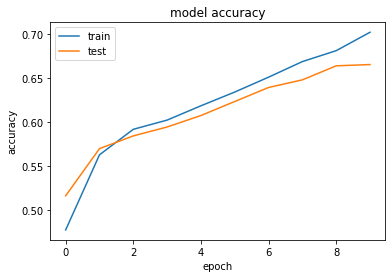

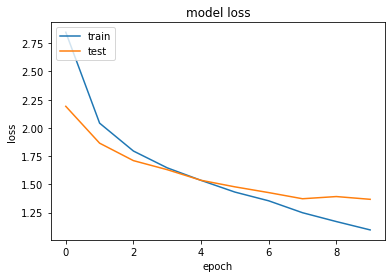

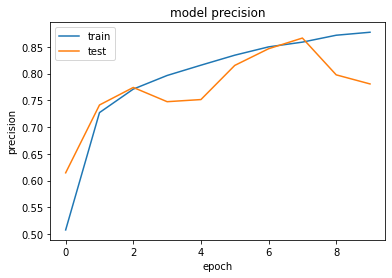

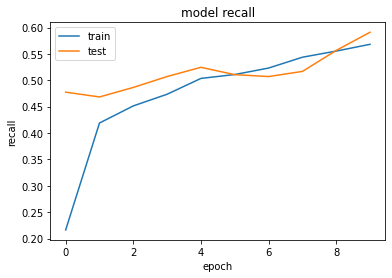

In [0]:
from matplotlib import pyplot as plt
try:
  plt.plot(history_emb_lstm.history['accuracy'])
  plt.plot(history_emb_lstm.history['val_accuracy'])
except:
  plt.plot(history_emb_lstm.history['acc'])
  plt.plot(history_emb_lstm.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_emb_lstm.history['loss'])
plt.plot(history_emb_lstm.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for mse
plt.plot(history_emb_lstm.history['precision'])
plt.plot(history_emb_lstm.history['val_precision'])
plt.title('model precision')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for mae
plt.plot(history_emb_lstm.history['recall'])
plt.plot(history_emb_lstm.history['val_recall'])
plt.title('model recall')
plt.ylabel('recall')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
# Test accuracy
accuracy = model_emb_lstm.evaluate(X_test,Y_test)
print('Test Accuracy: %.2f%%' %(accuracy[1]*100))

768/768 [==============================] - 9s 12ms/sample - loss: 1.4691 - acc: 0.6341 - precision: 0.7769 - recall: 0.5586
Test Accuracy: 63.41%


In [0]:
# Getting the confusion matrix
pred = model_emb_lstm.predict(X_test)
matrix = metrics.confusion_matrix(Y_test.argmax(axis=1), pred.argmax(axis=1))
print(matrix)

[[340   0   1 ...   0   0   1]
 [  0   0   0 ...   0   1   0]
 [  1   0   7 ...   0   1   0]
 ...
 [  1   0   0 ...   0   0   0]
 [  1   0   1 ...   0  51   0]
 [  6   0   0 ...   0  23   2]]


In [0]:
# Saving this model
model_emb_lstm.save("model_emb_lstm.h5")
print("Saved model_emb_lstm to disk")

Saved model_emb_lstm to disk


# Model - Bidirectional LSTM with 200D Glove Embeddings, 7672 records

In [0]:
# main model
input = Input(shape=(maxlen,))
model_emb_bilstm = Embedding(num_words,embedding_size,weights=[embedding_matrix],input_length=maxlen)(input)
model_emb_bilstm =  Bidirectional (LSTM (200,return_sequences=True,dropout=0.50),merge_mode='concat')(model_emb_bilstm)
model_emb_bilstm = TimeDistributed(Dense(200,activation='relu'))(model_emb_bilstm)
model_emb_bilstm = Flatten()(model_emb_bilstm)
model_emb_bilstm = Dense(200,activation='relu')(model_emb_bilstm)
output = Dense(74,activation='softmax')(model_emb_bilstm)
model_emb_bilstm = Model(input,output)
model_emb_bilstm.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy',precision,recall])

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [0]:
model_emb_bilstm.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 926)]             0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 926, 200)          2591800   
_________________________________________________________________
bidirectional (Bidirectional (None, 926, 400)          641600    
_________________________________________________________________
time_distributed (TimeDistri (None, 926, 200)          80200     
_________________________________________________________________
flatten (Flatten)            (None, 185200)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 200)               37040200  
_________________________________________________________________
dense_3 (Dense)              (None, 74)                14874 

In [0]:
import time
batch_size = 256
epochs = 10

start = time.clock()
history_emb_bilstm = model_emb_bilstm.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])
end  = time.clock()
print('Duration taken: ',end-start,' secs')

Train on 6213 samples, validate on 691 samples
Epoch 1/10
6213/6213 [==============================] - 100s 16ms/sample - loss: 2.4684 - acc: 0.5167 - precision: 0.6646 - recall: 0.3221 - val_loss: 1.9242 - val_acc: 0.5572 - val_precision: 0.8711 - val_recall: 0.3837
Epoch 2/10
6213/6213 [==============================] - 96s 15ms/sample - loss: 1.8183 - acc: 0.5735 - precision: 0.7929 - recall: 0.4305 - val_loss: 1.6559 - val_acc: 0.5847 - val_precision: 0.7851 - val_recall: 0.4674
Epoch 3/10
6213/6213 [==============================] - 96s 15ms/sample - loss: 1.5833 - acc: 0.6156 - precision: 0.8133 - recall: 0.4758 - val_loss: 1.5856 - val_acc: 0.6136 - val_precision: 0.7565 - val_recall: 0.5385
Epoch 4/10
6213/6213 [==============================] - 97s 16ms/sample - loss: 1.4076 - acc: 0.6380 - precision: 0.8160 - recall: 0.5159 - val_loss: 1.5385 - val_acc: 0.6266 - val_precision: 0.7947 - val_recall: 0.5281
Epoch 5/10
6213/6213 [==============================] - 96s 15ms/sample 

In [0]:
# list all data in history
print(history_emb_bilstm.history.keys())

dict_keys(['loss', 'acc', 'precision', 'recall', 'val_loss', 'val_acc', 'val_precision', 'val_recall'])


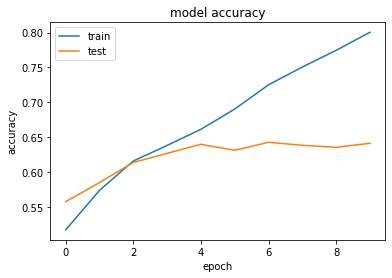

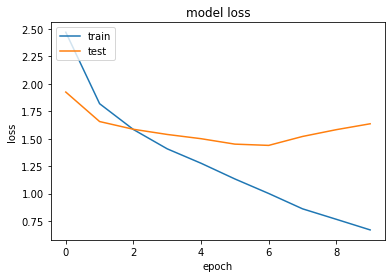

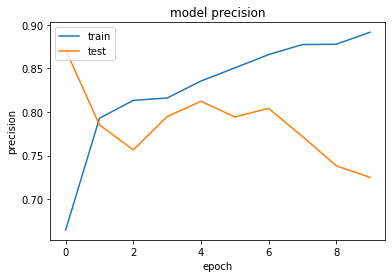

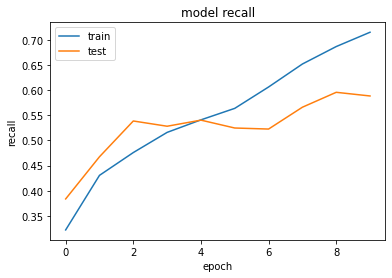

In [0]:
from matplotlib import pyplot as plt
try:
  plt.plot(history_emb_bilstm.history['accuracy'])
  plt.plot(history_emb_bilstm.history['val_accuracy'])
except:
  plt.plot(history_emb_bilstm.history['acc'])
  plt.plot(history_emb_bilstm.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_emb_bilstm.history['loss'])
plt.plot(history_emb_bilstm.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for mse
plt.plot(history_emb_bilstm.history['precision'])
plt.plot(history_emb_bilstm.history['val_precision'])
plt.title('model precision')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for mae
plt.plot(history_emb_bilstm.history['recall'])
plt.plot(history_emb_bilstm.history['val_recall'])
plt.title('model recall')
plt.ylabel('recall')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
# Test accuracy
accuracy = model_emb_bilstm.evaluate(X_test,Y_test)
print('Test Accuracy: %.2f%%' %(accuracy[1]*100))

768/768 [==============================] - 17s 22ms/sample - loss: 1.6919 - acc: 0.6029 - precision: 0.7093 - recall: 0.5443
Test Accuracy: 60.29%


In [0]:
# Getting the confusion matrix
pred = model_emb_bilstm.predict(X_test)
matrix = metrics.confusion_matrix(Y_test.argmax(axis=1), pred.argmax(axis=1))
print(matrix)

[[305   0   0 ...   0   0   3]
 [  0   0   0 ...   0   1   0]
 [  1   0   5 ...   0   1   0]
 ...
 [  1   0   0 ...   0   0   0]
 [  0   0   1 ...   0  52   1]
 [  5   0   1 ...   0  21   5]]


In [0]:
# Saving this model
model_emb_bilstm.save("model_emb_bilstm.h5")
print("Saved model_emb_bilstm to disk")

Saved model_emb_bilstm to disk


# Model - Bidirectional LSTM without glove embeddings, 7672 records

In [0]:
# main model
input = Input(shape=(maxlen,))
model_sim_bilstm = Embedding(num_words,embedding_size,input_length=maxlen)(input)
model_sim_bilstm =  Bidirectional (LSTM (200,return_sequences=True,dropout=0.50),merge_mode='concat')(model_sim_bilstm)
model_sim_bilstm = TimeDistributed(Dense(200,activation='relu'))(model_sim_bilstm)
model_sim_bilstm = Flatten()(model_sim_bilstm)
model_sim_bilstm = Dense(200,activation='relu')(model_sim_bilstm)
output = Dense(74,activation='softmax')(model_sim_bilstm)
model_sim_bilstm = Model(input,output)
model_sim_bilstm.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy',precision,recall])

In [0]:
model_sim_bilstm.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 926)]             0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 926, 200)          2591800   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 926, 400)          641600    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 926, 200)          80200     
_________________________________________________________________
flatten_1 (Flatten)          (None, 185200)            0         
_________________________________________________________________
dense_5 (Dense)              (None, 200)               37040200  
_________________________________________________________________
dense_6 (Dense)              (None, 74)                1487

In [0]:
import time
batch_size = 256
epochs = 10

start = time.clock()
history_sim_bilstm = model_sim_bilstm.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])
end  = time.clock()
print('Duration taken: ',end-start,' secs')

Train on 6213 samples, validate on 691 samples
Epoch 1/10
6213/6213 [==============================] - 109s 18ms/sample - loss: 3.0203 - acc: 0.4495 - precision: 0.3396 - recall: 0.1823 - val_loss: 2.3216 - val_acc: 0.5123 - val_precision: 0.5241 - val_recall: 0.5097
Epoch 2/10
6213/6213 [==============================] - 105s 17ms/sample - loss: 2.1448 - acc: 0.5498 - precision: 0.7305 - recall: 0.3991 - val_loss: 1.9515 - val_acc: 0.5615 - val_precision: 0.8615 - val_recall: 0.4049
Epoch 3/10
6213/6213 [==============================] - 104s 17ms/sample - loss: 1.7828 - acc: 0.5825 - precision: 0.8449 - recall: 0.4671 - val_loss: 1.7811 - val_acc: 0.5702 - val_precision: 0.8657 - val_recall: 0.4373
Epoch 4/10
6213/6213 [==============================] - 106s 17ms/sample - loss: 1.5697 - acc: 0.6137 - precision: 0.8767 - recall: 0.5005 - val_loss: 1.7104 - val_acc: 0.5904 - val_precision: 0.8319 - val_recall: 0.4550
Epoch 5/10
6213/6213 [==============================] - 106s 17ms/sam

In [0]:
# list all data in history
print(history_sim_bilstm.history.keys())

dict_keys(['loss', 'acc', 'precision', 'recall', 'val_loss', 'val_acc', 'val_precision', 'val_recall'])


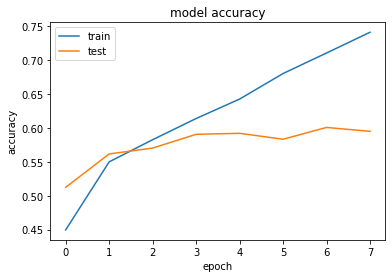

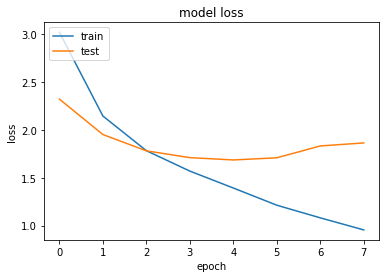

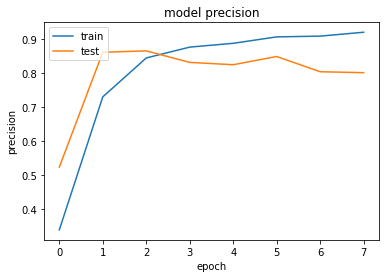

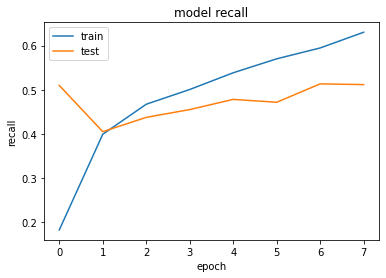

In [0]:
from matplotlib import pyplot as plt
try:
  plt.plot(history_sim_bilstm.history['accuracy'])
  plt.plot(history_sim_bilstm.history['val_accuracy'])
except:
  plt.plot(history_sim_bilstm.history['acc'])
  plt.plot(history_sim_bilstm.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_sim_bilstm.history['loss'])
plt.plot(history_sim_bilstm.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for mse
plt.plot(history_sim_bilstm.history['precision'])
plt.plot(history_sim_bilstm.history['val_precision'])
plt.title('model precision')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for mae
plt.plot(history_sim_bilstm.history['recall'])
plt.plot(history_sim_bilstm.history['val_recall'])
plt.title('model recall')
plt.ylabel('recall')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
# Test accuracy
accuracy = model_sim_bilstm.evaluate(X_test,Y_test)
print('Test Accuracy: %.2f%%' %(accuracy[1]*100))

768/768 [==============================] - 17s 22ms/sample - loss: 2.0937 - acc: 0.5859 - precision: 0.8044 - recall: 0.4831
Test Accuracy: 58.59%


In [0]:
# Getting the confusion matrix
pred = model_sim_bilstm.predict(X_test)
matrix = metrics.confusion_matrix(Y_test.argmax(axis=1), pred.argmax(axis=1))
print(matrix)

[[308   0   0 ...   0   0   1]
 [  0   0   0 ...   0   1   0]
 [  0   0   5 ...   0   1   0]
 ...
 [  1   0   0 ...   0   0   0]
 [  0   0   1 ...   0  49   0]
 [  4   0   0 ...   0  23   0]]


In [0]:
# Saving this model
model_sim_bilstm.save("model_sim_bilstm.h5")
print("Saved model_sim_bilstm to disk")

Saved model_sim_bilstm to disk


In [0]:
# Now on observing the accuracy we find that it is low, so we need to add data. Now, we will try to add the translated non_eng data with this dataset. Also group_0 is excluded in the translated non=eng data as it is the dominating label and it will effect the recall value

# Merging translated non english data with our dataset to increase data

In [0]:
# import necessary libraries
import pprint, pickle
import warnings, pickle, inflect, re
import os, sys, itertools, string
from wordcloud import STOPWORDS
from nltk.tokenize import regexp_tokenize
from nltk.corpus import stopwords
import spacy
import nltk
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [0]:
# Loaded the translated non-english data
pkl_file = open('trans_non_eng_data.pkl', 'rb')
translated_data = pickle.load(pkl_file)

pkl_file.close()

In [0]:
translated_data.head()

,Short description,Description,Caller,Assignment group
0,[urgent!!] delivery note creation request!!,\n\nreceived from: fbvpcytz.nokypgvx@gmail.com...,fbvpcytz nokypgvx,GRP_18
1,unable to access password_management_tool id p...,i try to change now my password acc. to attach...,ijeqpkrz nwtehsyx,GRP_2
2,Qingdao-the Electrical and Mechanical-mail shi...,"from: sent: friday, october 28, 2016 7:20 am ...",yafxlpwi lhxvatkb,GRP_18
3,support for fa.gstry \ arexjftu ohxdwngl,support for fa.konnica \ arexjftu ohxdwngl,arexjftu ohxdwngl,GRP_24
4,problems with blue screen,". hello, it happened again. the pc hanged hims...",vrfpyjwi nzhvgqiw,GRP_24


In [0]:
# Merging short description and description to one column named Combined description
translated_data['Combined description'] = translated_data.apply(lambda x:'%s %s' % (x['Short description'],x['Description']),axis=1)

In [0]:
# Dropping short description and description
translated_data.drop(columns=['Short description','Description'],inplace=True)

In [0]:
# Aligning the dataset
translated_data = translated_data[['Caller','Combined description','Assignment group']]

In [0]:
translated_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 567 entries, 0 to 566
Data columns (total 3 columns):
Caller                  567 non-null object
Combined description    567 non-null object
Assignment group        567 non-null object
dtypes: object(3)
memory usage: 13.4+ KB


In [0]:
# Find out the null value counts in each column
translated_data.isnull().sum()

Caller                  0
Combined description    0
Assignment group        0
dtype: int64

In [0]:
nltk.download("wordnet")
nltk.download("stopwords")

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [0]:
!python -m spacy download en
!python -m spacy download en_core_web_lg
import spacy.cli
spacy.cli.download("en_core_web_lg")

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


In [0]:
# Initialize spacy 'en' large model, keeping only tagger component needed for lemmatization
nlp = spacy.load('en_core_web_lg', disable=['parser', 'ner'])

In [0]:
# Tokenization using Regexp_tokenizer so that we get only words and digits in the token
def tokenizer(text):
  return regexp_tokenize(text,pattern="\w+")

#Lemmatization Using Spacy
def lemmatizer(sentence):
    # Parse the sentence using the loaded 'en' model object `nlp`
    doc = nlp(sentence)
    return " ".join([token.lemma_ for token in doc if token.lemma_ !='-PRON-'])

#stop words using NLTK
def stopWordsRemoval():
  mylist = stopwords.words('english')
  # mylist = mylist.extend(['yes','na','hi','receive','hello','regards','thanks','from','greeting','will','please','see','help','able'])
  return mylist
  

  # Extend the English Stop Words for the words imported from wordnet
STOP_WORDS = STOPWORDS.union({'yes','na','hi',
                              'receive','hello',
                              'regards','thanks',
                              'from','greeting',
                              'forward','reply',
                              'will','please',
                              'see','help','able'})

# Define regex patterns
EMAIL_PATTERN = r"([\w.+-]+@[a-z\d-]+\.[a-z\d.-]+)"
PUNCT_PATTERN = r"[,|@|\|?|\\|$&*|%|\r|\n|.:|\s+|/|//|\\|/|\||-|<|>|;|(|)|=|+|#|-|\"|[-\]]|{|}]"
# Negative Lookbehind for EmailId replacement- Don't match any number which follows the text "RetainedEmailId"
NUMER_PATTERN = r"(?<!RetainedEmailId)(\d+(?:\.\d+)?)"
def cleanseText(text):
    # Make the text unicase (lower) 
    text = str(text).lower()
    # Remove email adresses
    # text = re.sub(EMAIL_PATTERN, '', text, flags=re.IGNORECASE)
    # Save Email addresses and replace them with custom keyword
    email_dict = extract_email(text)
    for key in email_dict.keys():
        text = text.replace(email_dict[key], key)
    # Remove all numbers 
    text = re.sub(NUMER_PATTERN, '', text)
    # Replace all punctuations with blank space
    # text = re.sub(PUNCT_PATTERN, " ", text, flags=re.MULTILINE)
    text = text.translate(str.maketrans("","", string.punctuation))
    text = re.sub(r'\s+', ' ', text)
    # Replace multiple spaces from prev step to single
    text = re.sub(r' {2,}', " ", text, flags=re.MULTILINE)
    text = text.replace('`',"'")
    # Replace the email ids back into their original position
    for key in email_dict.keys():
        text = text.replace(key, email_dict[key])
    return text.strip()



def extract_email(text):
    # Replaces the email addresses with custom key word and 
    # save them into a dictionary for future use
    unique_emailid = set(re.findall(EMAIL_PATTERN, text))
    email_replacement = dict()
    for idx, email in enumerate(unique_emailid):
        email_replacement[f'RetainedEmailId{idx}'] = email
    return email_replacement
  # This method callsthe cleanseTest, tokenizer and the lemmatization function
def preProcessData(text):
  cleansedText = cleanseText(text)
  tokenized = tokenizer(cleansedText)
  lemmatizedText = lemmatizer(" ".join(word for word in tokenized))
  return lemmatizedText
  
stwords = stopWordsRemoval()
STOP_WORDS.union(set(stwords))
STOP_WORDS.remove('no')
STOP_WORDS.remove('not')
# function to remove all the stopwords
def removeStopWords(text):
  return " ".join([words.strip() for words in text.split() if words.strip() not in list(STOP_WORDS)])

In [0]:
# Apply the cleaning function to entire dataset
translated_data['Combined description'] = translated_data['Combined description'].apply(preProcessData)

In [0]:
# Apply the stopwords removal function to entire dataset
translated_data['Combined description'] = translated_data['Combined description'].apply(removeStopWords)

In [0]:
# Verify the data
translated_data.tail()

,Caller,Combined description,Assignment group
562,azxhejvq fyemlavd,review recent ticketingtool ticket let know mo...,GRP_16
563,xqyjztnm onfusvlz,boot computer not really come koga not come mo...,GRP_30
564,nlearzwi ukdzstwi,customer group enhanced field nlearzwi ukdzstw...,GRP_9
565,ufawcgob aowhxjky,machine não está funcionando unable access mac...,GRP_62
566,kqvbrspl jyzoklfx,various prgramdntyme not open multiple pc vari...,GRP_49


In [0]:
# Merging two dataset to get a bigger dataset
final_dataset = pd.concat([processedEnglishData, translated_data], axis=0, sort=False)

In [0]:
final_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8239 entries, 0 to 566
Data columns (total 4 columns):
Caller                  8239 non-null object
Combined description    8239 non-null object
Assignment group        8239 non-null object
len                     7672 non-null float64
dtypes: float64(1), object(3)
memory usage: 321.8+ KB


In [0]:
# Including a len column to find the maximum length of each cell
final_dataset['len'] = final_dataset['Combined description'].apply(lambda x: len(x.split(" ")))
final_dataset.head()

,Caller,Combined description,Assignment group,len
0,spxjnwir pjlcoqds,login issue verify user detailsemployee manage...,GRP_0,22
1,hmjdrvpb komuaywn,outlook hmjdrvpb komuaywn gmail team meetingss...,GRP_0,16
2,eylqgodm ybqkwiam,not log vpn eylqgodm ybqkwiam gmail not log vp...,GRP_0,10
3,xbkucsvz gcpydteq,unable access hrtool page unable access hrtool...,GRP_0,8
4,owlgqjme qhcozdfx,skype error skype error,GRP_0,4


In [0]:
# Saving the dataset for future use
output = open('final_processed_dataset.pkl', 'wb')
pickle.dump(final_dataset, output)
output.close()

In [0]:
maxlen=max(final_dataset['len'])
print(maxlen)

926


In [0]:
max_features = 50000
maxlen = maxlen
embedding_size = 200
tokenizer = Tokenizer(num_words=max_features, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(final_dataset['Combined description'].values)
X = tokenizer.texts_to_sequences(final_dataset['Combined description'].values)
X = pad_sequences(X, maxlen=maxlen)
print('Shape of data tensor:', X.shape)
Y = pd.get_dummies(final_dataset['Assignment group']).values
print('Shape of label tensor:', Y.shape)
## Get the Vocabulary size
num_words = len(tokenizer.word_index) + 1
print(num_words)

Shape of data tensor: (8239, 926)
Shape of label tensor: (8239, 74)
15139


In [0]:
# Get the Word Embeddings using Embedding file
EMBEDDING_FILE = './glove.6B.200d.txt'

embeddings = {}
for o in open(EMBEDDING_FILE):
    word = o.split(" ")[0]
    # print(word)
    embd = o.split(" ")[1:]
    embd = np.asarray(embd, dtype='float32')
    # print(embd)
    embeddings[word] = embd

In [0]:
# Create a weight matrix for words in training docs
embedding_matrix = np.zeros((num_words, embedding_size))

for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

len(embeddings.values())

400000

In [0]:
X_train3, X_test3, Y_train3, Y_test3 = train_test_split(X,Y, test_size = 0.10, random_state = 42)
print(X_train3.shape,Y_train3.shape)
print(X_test3.shape,Y_test3.shape)

(7415, 926) (7415, 74)
(824, 926) (824, 74)


In [0]:
import keras.backend as K
def precision(y_true, y_pred): 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision
def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

## Model - BiLSTM with 200D glove embeddings built on bigger dataset with 8239 records

In [0]:
# main model
input = Input(shape=(maxlen,))
model_emb_bilstm2 = Embedding(num_words,embedding_size,weights=[embedding_matrix],input_length=maxlen)(input)
model_emb_bilstm2 =  Bidirectional (LSTM (200,return_sequences=True,dropout=0.50),merge_mode='concat')(model_emb_bilstm2)
model_emb_bilstm2 = TimeDistributed(Dense(200,activation='relu'))(model_emb_bilstm2)
model_emb_bilstm2 = Flatten()(model_emb_bilstm2)
model_emb_bilstm2 = Dense(200,activation='relu')(model_emb_bilstm2)
output = Dense(74,activation='softmax')(model_emb_bilstm2)
model_emb_bilstm2 = Model(input,output)
model_emb_bilstm2.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy',precision,recall])

In [0]:
model_emb_bilstm2.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 926)]             0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 926, 200)          3027800   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 926, 400)          641600    
_________________________________________________________________
time_distributed_2 (TimeDist (None, 926, 200)          80200     
_________________________________________________________________
flatten_2 (Flatten)          (None, 185200)            0         
_________________________________________________________________
dense_8 (Dense)              (None, 200)               37040200  
_________________________________________________________________
dense_9 (Dense)              (None, 74)                1487

In [0]:
import time
batch_size = 256
epochs = 10

start = time.clock()
history_emb_bilstm2 = model_emb_bilstm2.fit(X_train3, Y_train3, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])
end  = time.clock()
print('Duration taken: ',end-start,' secs')

Train on 6673 samples, validate on 742 samples
Epoch 1/10
6673/6673 [==============================] - 121s 18ms/sample - loss: 2.6258 - acc: 0.4818 - precision: 0.6385 - recall: 0.2846 - val_loss: 2.1455 - val_acc: 0.5202 - val_precision: 0.7923 - val_recall: 0.3473
Epoch 2/10
6673/6673 [==============================] - 120s 18ms/sample - loss: 1.9877 - acc: 0.5524 - precision: 0.7816 - recall: 0.3849 - val_loss: 1.8875 - val_acc: 0.5755 - val_precision: 0.8942 - val_recall: 0.3975
Epoch 3/10
6673/6673 [==============================] - 120s 18ms/sample - loss: 1.7447 - acc: 0.5810 - precision: 0.8177 - recall: 0.4442 - val_loss: 1.7617 - val_acc: 0.5836 - val_precision: 0.7584 - val_recall: 0.4964
Epoch 4/10
6673/6673 [==============================] - 119s 18ms/sample - loss: 1.5903 - acc: 0.6029 - precision: 0.8162 - recall: 0.4656 - val_loss: 1.6619 - val_acc: 0.5957 - val_precision: 0.7935 - val_recall: 0.5074
Epoch 5/10
6673/6673 [==============================] - 119s 18ms/sam

In [0]:
# list all data in history
print(history_emb_bilstm2.history.keys())

dict_keys(['loss', 'acc', 'precision', 'recall', 'val_loss', 'val_acc', 'val_precision', 'val_recall'])


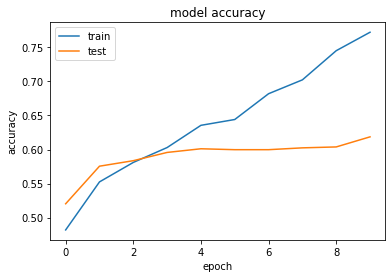

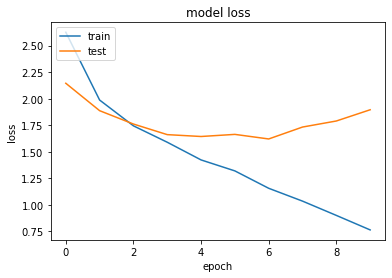

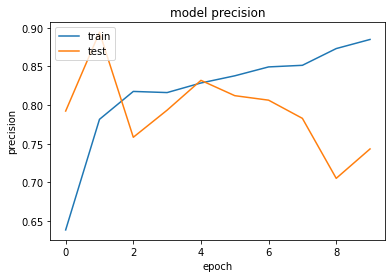

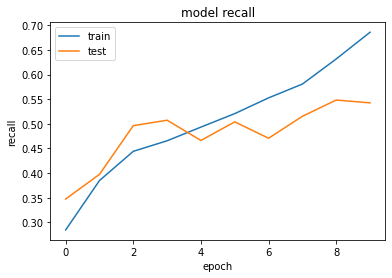

In [0]:
from matplotlib import pyplot as plt
try:
  plt.plot(history_emb_bilstm2.history['accuracy'])
  plt.plot(history_emb_bilstm2.history['val_accuracy'])
except:
  plt.plot(history_emb_bilstm2.history['acc'])
  plt.plot(history_emb_bilstm2.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_emb_bilstm2.history['loss'])
plt.plot(history_emb_bilstm2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for mse
plt.plot(history_emb_bilstm2.history['precision'])
plt.plot(history_emb_bilstm2.history['val_precision'])
plt.title('model precision')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for mae
plt.plot(history_emb_bilstm2.history['recall'])
plt.plot(history_emb_bilstm2.history['val_recall'])
plt.title('model recall')
plt.ylabel('recall')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
# Test accuracy
accuracy = model_emb_bilstm2.evaluate(X_test3,Y_test3)
print('Test Accuracy: %.2f%%' %(accuracy[1]*100))

824/824 [==============================] - 17s 21ms/sample - loss: 1.8825 - acc: 0.6189 - precision: 0.7187 - recall: 0.5473
Test Accuracy: 61.89%


In [0]:
# Getting the confusion matrix
pred = model_emb_bilstm2.predict(X_test3)
matrix = metrics.confusion_matrix(Y_test3.argmax(axis=1), pred.argmax(axis=1))
print(matrix)

[[335   0   1 ...   0   0   0]
 [  0   0   0 ...   0   1   0]
 [  0   0   2 ...   0   0   0]
 ...
 [  0   0   0 ...   0   0   0]
 [  0   0   1 ...   0  40  15]
 [  8   0   1 ...   0   0  15]]


In [0]:
# Saving this model
model_emb_bilstm2.save("model_emb_bilstm2.h5")
print("Saved model_emb_bilstm2 to disk")

Saved model_emb_bilstm2 to disk


# Model - BiLSTM with 300D glove embeddings , additional dense layer, 8239 records

In [0]:
max_features = 50000
maxlen = maxlen
embedding_size = 300
tokenizer = Tokenizer(num_words=max_features, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(final_dataset['Combined description'].values)
X = tokenizer.texts_to_sequences(final_dataset['Combined description'].values)
X = pad_sequences(X, maxlen=maxlen)
print('Shape of data tensor:', X.shape)
Y = pd.get_dummies(final_dataset['Assignment group']).values
print('Shape of label tensor:', Y.shape)
## Get the Vocabulary size
num_words = len(tokenizer.word_index) + 1
print(num_words)

Shape of data tensor: (8239, 926)
Shape of label tensor: (8239, 74)
15139


In [0]:
# Get the Word Embeddings using Embedding file
EMBEDDING_FILE = './glove.6B.300d.txt'

embeddings = {}
for o in open(EMBEDDING_FILE):
    word = o.split(" ")[0]
    # print(word)
    embd = o.split(" ")[1:]
    embd = np.asarray(embd, dtype='float32')
    # print(embd)
    embeddings[word] = embd

In [0]:
# Create a weight matrix for words in training docs
embedding_matrix = np.zeros((num_words, embedding_size))

for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

len(embeddings.values())

400000

In [0]:
X_train4, X_test4, Y_train4, Y_test4 = train_test_split(X,Y, test_size = 0.10, random_state = 42)
print(X_train4.shape,Y_train4.shape)
print(X_test4.shape,Y_test4.shape)

(7415, 926) (7415, 74)
(824, 926) (824, 74)


In [0]:
import keras.backend as K
def precision(y_true, y_pred): 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision
def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

In [0]:
# main model
input = Input(shape=(maxlen,))
model_emb_bilstm3 = Embedding(num_words,embedding_size,weights=[embedding_matrix],input_length=maxlen)(input)
model_emb_bilstm3 =  Bidirectional (LSTM (300,return_sequences=True,dropout=0.50),merge_mode='concat')(model_emb_bilstm3)
model_emb_bilstm3 = TimeDistributed(Dense(300,activation='relu'))(model_emb_bilstm3)
model_emb_bilstm3 = Flatten()(model_emb_bilstm3)
model_emb_bilstm3 = Dense(300,activation='relu')(model_emb_bilstm3)
model_emb_bilstm3 = Flatten()(model_emb_bilstm3)
model_emb_bilstm3 = Dense(187,activation='relu')(model_emb_bilstm3)
output = Dense(74,activation='softmax')(model_emb_bilstm3)
model_emb_bilstm3 = Model(input,output)
model_emb_bilstm3.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy',precision,recall])

In [0]:
model_emb_bilstm3.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 926)]             0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 926, 300)          4541700   
_________________________________________________________________
bidirectional_3 (Bidirection (None, 926, 600)          1442400   
_________________________________________________________________
time_distributed_3 (TimeDist (None, 926, 300)          180300    
_________________________________________________________________
flatten_3 (Flatten)          (None, 277800)            0         
_________________________________________________________________
dense_11 (Dense)             (None, 300)               83340300  
_________________________________________________________________
flatten_4 (Flatten)          (None, 300)               0   

In [0]:
import time
batch_size = 256
epochs = 10

start = time.clock()
history_emb_bilstm3 = model_emb_bilstm3.fit(X_train4, Y_train4, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])
end  = time.clock()
print('Duration taken: ',end-start,' secs')

Train on 6673 samples, validate on 742 samples
Epoch 1/10
6673/6673 [==============================] - 164s 25ms/sample - loss: 2.6677 - acc: 0.4740 - precision: 0.6640 - recall: 0.2822 - val_loss: 2.1304 - val_acc: 0.5027 - val_precision: 0.7360 - val_recall: 0.4380
Epoch 2/10
6673/6673 [==============================] - 160s 24ms/sample - loss: 1.9618 - acc: 0.5506 - precision: 0.7926 - recall: 0.4034 - val_loss: 1.8534 - val_acc: 0.5566 - val_precision: 0.8448 - val_recall: 0.4262
Epoch 3/10
6673/6673 [==============================] - 158s 24ms/sample - loss: 1.7189 - acc: 0.5855 - precision: 0.8121 - recall: 0.4383 - val_loss: 1.7193 - val_acc: 0.5849 - val_precision: 0.8523 - val_recall: 0.4631
Epoch 4/10
6673/6673 [==============================] - 160s 24ms/sample - loss: 1.5217 - acc: 0.6101 - precision: 0.8490 - recall: 0.4761 - val_loss: 1.6125 - val_acc: 0.6092 - val_precision: 0.8030 - val_recall: 0.5078
Epoch 5/10
6673/6673 [==============================] - 158s 24ms/sam

In [0]:
# list all data in history
print(history_emb_bilstm3.history.keys())

dict_keys(['loss', 'acc', 'precision', 'recall', 'val_loss', 'val_acc', 'val_precision', 'val_recall'])


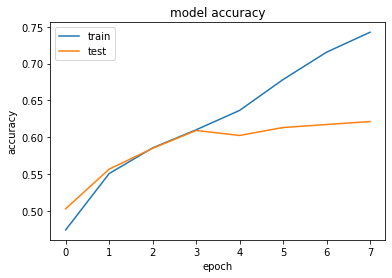

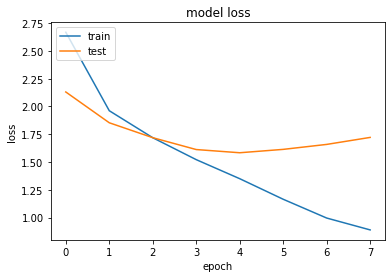

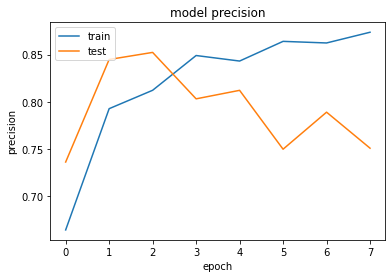

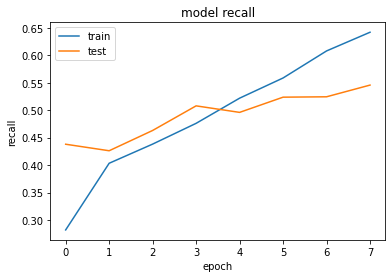

In [0]:
from matplotlib import pyplot as plt
try:
  plt.plot(history_emb_bilstm3.history['accuracy'])
  plt.plot(history_emb_bilstm3.history['val_accuracy'])
except:
  plt.plot(history_emb_bilstm3.history['acc'])
  plt.plot(history_emb_bilstm3.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_emb_bilstm3.history['loss'])
plt.plot(history_emb_bilstm3.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for mse
plt.plot(history_emb_bilstm3.history['precision'])
plt.plot(history_emb_bilstm3.history['val_precision'])
plt.title('model precision')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for mae
plt.plot(history_emb_bilstm3.history['recall'])
plt.plot(history_emb_bilstm3.history['val_recall'])
plt.title('model recall')
plt.ylabel('recall')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
# Test accuracy
accuracy = model_emb_bilstm3.evaluate(X_test4,Y_test4)
print('Test Accuracy: %.2f%%' %(accuracy[1]*100))

824/824 [==============================] - 19s 23ms/sample - loss: 1.7724 - acc: 0.6214 - precision: 0.7440 - recall: 0.5549
Test Accuracy: 62.14%


In [0]:
# Getting the confusion matrix
pred = model_emb_bilstm3.predict(X_test4)
matrix = metrics.confusion_matrix(Y_test4.argmax(axis=1), pred.argmax(axis=1))
print(matrix)

[[319   0   1 ...   0   0   0]
 [  0   0   0 ...   0   1   0]
 [  0   0   2 ...   0   0   0]
 ...
 [  0   0   0 ...   0   0   0]
 [  0   0   1 ...   0  55   1]
 [  4   0   0 ...   0  12   6]]


In [0]:
# Saving this model
model_emb_bilstm3.save("model_emb_bilstm3.h5")
print("Saved model_emb_bilstm3 to disk")

Saved model_emb_bilstm3 to disk


In [0]:
# On getting low accuracy we will try to upsample the dataset

## Upsampling the groups having less than 500 records to 500 records

In [0]:
# Loaded the final translated data
pkl_file = open('final_processed_dataset.pkl', 'rb')
final_dataset = pickle.load(pkl_file)

pkl_file.close()

In [0]:
from sklearn.utils import resample

In [0]:
labels = final_dataset['Assignment group'].unique()
print(labels)

['GRP_0' 'GRP_1' 'GRP_3' 'GRP_4' 'GRP_5' 'GRP_6' 'GRP_7' 'GRP_8' 'GRP_9'
 'GRP_10' 'GRP_11' 'GRP_12' 'GRP_13' 'GRP_14' 'GRP_15' 'GRP_16' 'GRP_17'
 'GRP_19' 'GRP_20' 'GRP_21' 'GRP_22' 'GRP_2' 'GRP_23' 'GRP_18' 'GRP_25'
 'GRP_26' 'GRP_27' 'GRP_28' 'GRP_24' 'GRP_29' 'GRP_31' 'GRP_33' 'GRP_34'
 'GRP_35' 'GRP_36' 'GRP_37' 'GRP_40' 'GRP_41' 'GRP_42' 'GRP_43' 'GRP_44'
 'GRP_45' 'GRP_46' 'GRP_47' 'GRP_50' 'GRP_51' 'GRP_52' 'GRP_53' 'GRP_39'
 'GRP_54' 'GRP_55' 'GRP_57' 'GRP_58' 'GRP_59' 'GRP_60' 'GRP_61' 'GRP_32'
 'GRP_56' 'GRP_63' 'GRP_64' 'GRP_62' 'GRP_48' 'GRP_65' 'GRP_30' 'GRP_38'
 'GRP_49' 'GRP_66' 'GRP_67' 'GRP_68' 'GRP_69' 'GRP_70' 'GRP_71' 'GRP_72'
 'GRP_73']


In [0]:
# Looking at the numbers of different records
final_dataset['Assignment group'].value_counts()

GRP_0     3715
GRP_8      661
GRP_24     289
GRP_12     257
GRP_9      252
          ... 
GRP_64       1
GRP_61       1
GRP_67       1
GRP_35       1
GRP_70       1
Name: Assignment group, Length: 74, dtype: int64

In [0]:
final_dataset[final_dataset['Assignment group']=='GRP_0'].shape[0]

3715

In [0]:
df = final_dataset.copy()

In [0]:
frames = []

In [0]:
labels[0]

'GRP_0'

In [0]:
df[df['Assignment group']==labels[0]].shape[0]>3715

False

In [0]:
# The groups which has less than 500 entries are upsampled to have 500 entries.
for x in labels:
  if df[df['Assignment group']==x].shape[0]>500:
    frames.append(df[df['Assignment group']==x])
  else:
    frames.append(resample(df[df['Assignment group']==x],replace=True,n_samples=500,random_state=123))

In [0]:
# Merging all upsampled and downsampled data into one master dataset
master_dataset = pd.concat(frames)

In [0]:
# Shuffling the dataset
master_dataset = master_dataset.sample(frac=1).reset_index(drop=True)

In [0]:
# Checking the dataset
master_dataset.info() # The dataset has been upsampled from 8239 records to 40376 records

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40376 entries, 0 to 40375
Data columns (total 4 columns):
Caller                  40376 non-null object
Combined description    40376 non-null object
Assignment group        40376 non-null object
len                     40376 non-null int64
dtypes: int64(1), object(3)
memory usage: 1.2+ MB


In [0]:
# looking at the different unique labels and their ordering after shuffling
labels = master_dataset['Assignment group'].unique()
print(labels)

['GRP_0' 'GRP_66' 'GRP_72' 'GRP_49' 'GRP_25' 'GRP_73' 'GRP_68' 'GRP_39'
 'GRP_27' 'GRP_45' 'GRP_13' 'GRP_29' 'GRP_40' 'GRP_60' 'GRP_17' 'GRP_50'
 'GRP_58' 'GRP_65' 'GRP_21' 'GRP_26' 'GRP_70' 'GRP_5' 'GRP_15' 'GRP_43'
 'GRP_63' 'GRP_62' 'GRP_34' 'GRP_64' 'GRP_23' 'GRP_56' 'GRP_46' 'GRP_9'
 'GRP_67' 'GRP_48' 'GRP_41' 'GRP_4' 'GRP_20' 'GRP_59' 'GRP_35' 'GRP_71'
 'GRP_1' 'GRP_11' 'GRP_44' 'GRP_36' 'GRP_30' 'GRP_18' 'GRP_31' 'GRP_19'
 'GRP_33' 'GRP_52' 'GRP_37' 'GRP_6' 'GRP_16' 'GRP_28' 'GRP_22' 'GRP_55'
 'GRP_8' 'GRP_10' 'GRP_57' 'GRP_61' 'GRP_38' 'GRP_2' 'GRP_3' 'GRP_51'
 'GRP_7' 'GRP_32' 'GRP_24' 'GRP_14' 'GRP_69' 'GRP_47' 'GRP_42' 'GRP_54'
 'GRP_12' 'GRP_53']


In [0]:
# Looking at the numbers of records for different groups
master_dataset['Assignment group'].value_counts()

GRP_0     3715
GRP_8      661
GRP_42     500
GRP_50     500
GRP_20     500
          ... 
GRP_37     500
GRP_3      500
GRP_46     500
GRP_32     500
GRP_28     500
Name: Assignment group, Length: 74, dtype: int64

In [0]:
# saving the sampled dataset
output = open('sampled_dataset.pkl', 'wb')
pickle.dump(master_dataset, output)
output.close()

In [0]:
# Loaded the sampled dataset
pkl_file = open('sampled_dataset.pkl', 'rb')
master_dataset = pickle.load(pkl_file)

pkl_file.close()

In [22]:
max_features = 50000
maxlen = 926
embedding_size = 300
tokenizer = Tokenizer(num_words=max_features, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(master_dataset['Combined description'].values)
X = tokenizer.texts_to_sequences(master_dataset['Combined description'].values)
X = pad_sequences(X, maxlen=maxlen)
print('Shape of data tensor:', X.shape)
Y_frame = pd.get_dummies(master_dataset['Assignment group'])

Shape of data tensor: (40376, 926)


In [23]:
# After the categorical data converted to dummies let's check the data
Y_frame.head()

,GRP_0,GRP_1,GRP_10,GRP_11,GRP_12,GRP_13,GRP_14,GRP_15,GRP_16,GRP_17,GRP_18,GRP_19,GRP_2,GRP_20,GRP_21,GRP_22,GRP_23,GRP_24,GRP_25,GRP_26,GRP_27,GRP_28,GRP_29,GRP_3,GRP_30,GRP_31,GRP_32,GRP_33,GRP_34,GRP_35,GRP_36,GRP_37,GRP_38,GRP_39,GRP_4,GRP_40,GRP_41,GRP_42,GRP_43,GRP_44,GRP_45,GRP_46,GRP_47,GRP_48,GRP_49,GRP_5,GRP_50,GRP_51,GRP_52,GRP_53,GRP_54,GRP_55,GRP_56,GRP_57,GRP_58,GRP_59,GRP_6,GRP_60,GRP_61,GRP_62,GRP_63,GRP_64,GRP_65,GRP_66,GRP_67,GRP_68,GRP_69,GRP_7,GRP_70,GRP_71,GRP_72,GRP_73,GRP_8,GRP_9
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
# Lets store the colummn names , so that we could use it for finding the group name at later stage
labelColumnNames = Y_frame.columns.values

In [25]:
# Checking the type of the labelColumnNames
type(labelColumnNames)

numpy.ndarray

In [26]:
print(labelColumnNames)

['GRP_0' 'GRP_1' 'GRP_10' 'GRP_11' 'GRP_12' 'GRP_13' 'GRP_14' 'GRP_15'
 'GRP_16' 'GRP_17' 'GRP_18' 'GRP_19' 'GRP_2' 'GRP_20' 'GRP_21' 'GRP_22'
 'GRP_23' 'GRP_24' 'GRP_25' 'GRP_26' 'GRP_27' 'GRP_28' 'GRP_29' 'GRP_3'
 'GRP_30' 'GRP_31' 'GRP_32' 'GRP_33' 'GRP_34' 'GRP_35' 'GRP_36' 'GRP_37'
 'GRP_38' 'GRP_39' 'GRP_4' 'GRP_40' 'GRP_41' 'GRP_42' 'GRP_43' 'GRP_44'
 'GRP_45' 'GRP_46' 'GRP_47' 'GRP_48' 'GRP_49' 'GRP_5' 'GRP_50' 'GRP_51'
 'GRP_52' 'GRP_53' 'GRP_54' 'GRP_55' 'GRP_56' 'GRP_57' 'GRP_58' 'GRP_59'
 'GRP_6' 'GRP_60' 'GRP_61' 'GRP_62' 'GRP_63' 'GRP_64' 'GRP_65' 'GRP_66'
 'GRP_67' 'GRP_68' 'GRP_69' 'GRP_7' 'GRP_70' 'GRP_71' 'GRP_72' 'GRP_73'
 'GRP_8' 'GRP_9']


In [0]:
# Saving unique labels which is needed later alongwith the model to find the predicted group
np.save('uniqueLabels',labelColumnNames)

In [28]:
# Shape of label tensor
Y = Y_frame.values
print('Shape of label tensor:', Y.shape)


Shape of label tensor: (40376, 74)


In [29]:
## Get the Vocabulary size
num_words = len(tokenizer.word_index) + 1
print(num_words)

14722


In [0]:
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [0]:
# Get the Word Embeddings using Embedding file
EMBEDDING_FILE = './glove.6B.300d.txt'

embeddings = {}
for o in open(EMBEDDING_FILE):
    word = o.split(" ")[0]
    # print(word)
    embd = o.split(" ")[1:]
    embd = np.asarray(embd, dtype='float32')
    # print(embd)
    embeddings[word] = embd

In [32]:
# Create a weight matrix for words in training docs
embedding_matrix = np.zeros((num_words, embedding_size))

for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

len(embeddings.values())

400000

In [33]:
# Splitting the dataset into train and test sets
X_train5, X_test5, Y_train5, Y_test5 = train_test_split(X,Y, test_size = 0.25, random_state = 42)
print(X_train5.shape,Y_train5.shape)
print(X_test5.shape,Y_test5.shape)

(30282, 926) (30282, 74)
(10094, 926) (10094, 74)


In [34]:
# Counts of number of entries assigned to different groups
print('Number of labels count in training and validation set')
print(Y_train5.sum(axis=0))
print(Y_test5.sum(axis=0))

Number of labels count in training and validation set
[2785  381  375  362  372  377  366  376  388  365  374  365  381  369
  365  377  359  395  364  374  360  383  390  390  367  372  383  379
  376  378  380  384  368  383  363  372  375  373  363  366  381  353
  364  378  385  392  381  361  359  389  388  360  383  385  373  378
  377  382  364  371  386  386  371  366  374  373  392  383  367  364
  360  370  524  387]
[930 119 125 138 128 123 134 124 112 135 126 135 119 131 135 123 141 105
 136 126 140 117 110 110 133 128 117 121 124 122 120 116 132 117 137 128
 125 127 137 134 119 147 136 122 115 108 119 139 141 111 112 140 117 115
 127 122 123 118 136 129 114 114 129 134 126 127 108 117 133 136 140 130
 137 113]


In [0]:
# Precision and Recall functions
import keras.backend as K
def precision(y_true, y_pred): 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision
def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

## Model - BiLSTM with 300D glove embeddings, on upsampled dataset with 40376 records

In [0]:
# main model
input = Input(shape=(maxlen,))
model_emb_bilstm4 = Embedding(num_words,embedding_size,weights=[embedding_matrix],input_length=maxlen)(input)
model_emb_bilstm4 =  Bidirectional (LSTM (300,return_sequences=True,dropout=0.50),merge_mode='concat')(model_emb_bilstm4)
model_emb_bilstm4 = TimeDistributed(Dense(300,activation='relu'))(model_emb_bilstm4)
model_emb_bilstm4 = Flatten()(model_emb_bilstm4)
model_emb_bilstm4 = Dense(300,activation='relu')(model_emb_bilstm4)
model_emb_bilstm4 = Dense(187,activation='relu')(model_emb_bilstm4)
output = Dense(74,activation='softmax')(model_emb_bilstm4)
model_emb_bilstm4 = Model(input,output)
model_emb_bilstm4.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy',precision,recall])

In [37]:
# looking at the model summary
model_emb_bilstm4.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 926)]             0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 926, 300)          4416600   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 926, 600)          1442400   
_________________________________________________________________
time_distributed_1 (TimeDist (None, 926, 300)          180300    
_________________________________________________________________
flatten_1 (Flatten)          (None, 277800)            0         
_________________________________________________________________
dense_5 (Dense)              (None, 300)               83340300  
_________________________________________________________________
dense_6 (Dense)              (None, 187)               5628

In [38]:
# Model fitting
import time
batch_size = 256
epochs = 10

start = time.clock()
history_emb_bilstm4 = model_emb_bilstm4.fit(X_train5, Y_train5, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])
end  = time.clock()
print('Duration taken: ',end-start,' secs')

Train on 27253 samples, validate on 3029 samples
Epoch 1/10
27253/27253 [==============================] - 634s 23ms/sample - loss: 1.8622 - acc: 0.5454 - precision: 0.8592 - recall: 0.4084 - val_loss: 0.6812 - val_acc: 0.8013 - val_precision: 0.9398 - val_recall: 0.7060
Epoch 2/10
27253/27253 [==============================] - 597s 22ms/sample - loss: 0.5270 - acc: 0.8440 - precision: 0.9386 - recall: 0.7836 - val_loss: 0.4513 - val_acc: 0.8742 - val_precision: 0.9467 - val_recall: 0.8300
Epoch 3/10
27253/27253 [==============================] - 604s 22ms/sample - loss: 0.3061 - acc: 0.9066 - precision: 0.9599 - recall: 0.8775 - val_loss: 0.2917 - val_acc: 0.9119 - val_precision: 0.9631 - val_recall: 0.8899
Epoch 4/10
27253/27253 [==============================] - 603s 22ms/sample - loss: 0.2197 - acc: 0.9299 - precision: 0.9704 - recall: 0.9113 - val_loss: 0.2697 - val_acc: 0.9201 - val_precision: 0.9604 - val_recall: 0.9087
Epoch 5/10
27253/27253 [==============================] - 5

In [39]:
# list all data in history
print(history_emb_bilstm4.history.keys())

dict_keys(['loss', 'acc', 'precision', 'recall', 'val_loss', 'val_acc', 'val_precision', 'val_recall'])


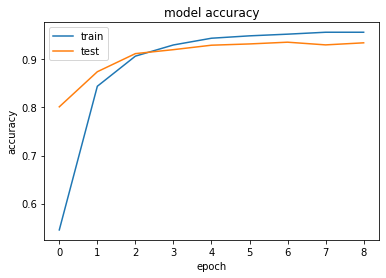

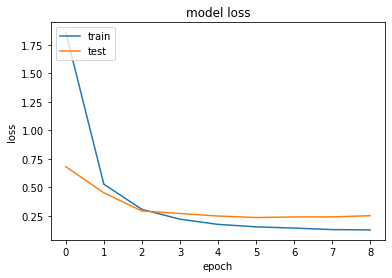

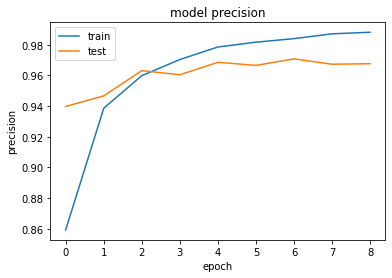

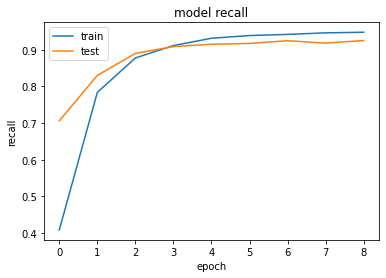

In [40]:
from matplotlib import pyplot as plt
try:
  plt.plot(history_emb_bilstm4.history['accuracy'])
  plt.plot(history_emb_bilstm4.history['val_accuracy'])
except:
  plt.plot(history_emb_bilstm4.history['acc'])
  plt.plot(history_emb_bilstm4.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_emb_bilstm4.history['loss'])
plt.plot(history_emb_bilstm4.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for mse
plt.plot(history_emb_bilstm4.history['precision'])
plt.plot(history_emb_bilstm4.history['val_precision'])
plt.title('model precision')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for mae
plt.plot(history_emb_bilstm4.history['recall'])
plt.plot(history_emb_bilstm4.history['val_recall'])
plt.title('model recall')
plt.ylabel('recall')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [41]:
# Test accuracy
accuracy = model_emb_bilstm4.evaluate(X_test5,Y_test5)
print('Test Accuracy: %.2f%%' %(accuracy[1]*100))

10094/10094 [==============================] - 203s 20ms/sample - loss: 0.2607 - acc: 0.9340 - precision: 0.9661 - recall: 0.9243
Test Accuracy: 93.40%


In [42]:
# Getting the confusion matrix
pred = model_emb_bilstm4.predict(X_test5)
matrix = metrics.confusion_matrix(Y_test5.argmax(axis=1), pred.argmax(axis=1))
print(matrix)

[[767   0   7 ...   0   0   0]
 [  0 113   0 ...   0   0   0]
 [  2   0  99 ...   0   0   2]
 ...
 [  0   0   0 ... 130   0   0]
 [  1   3   2 ...   0  61   6]
 [  0   0   0 ...   0   0  54]]


In [43]:
# Saving this model
model_emb_bilstm4.save("model_emb_bilstm_sampledData.h5")
print("Saved model_emb_bilstm_sampledData to disk")

Saved model_emb_bilstm_sampledData to disk


In [44]:
#Example
new_complaint = ['skype error skype error']
seq = tokenizer.texts_to_sequences(new_complaint)
padded = pad_sequences(seq, maxlen=maxlen)
pred = model_emb_bilstm4.predict(padded)
print(pred, labelColumnNames[np.argmax(pred)])

[[9.81896400e-01 9.64752100e-09 2.29588750e-06 4.42982582e-06
  4.92862137e-06 6.24527820e-05 2.02678311e-05 5.30914633e-07
  1.81270522e-07 1.85896909e-07 1.43686023e-07 1.50858527e-02
  7.99270128e-05 1.09074083e-09 2.39927402e-07 5.45387365e-06
  4.56346197e-06 4.87373145e-05 1.86153000e-06 3.43897227e-05
  1.91690674e-06 1.00068242e-07 9.32244984e-06 9.70999317e-05
  5.60303488e-06 7.68056314e-04 1.86906078e-07 1.14278623e-06
  3.05845751e-05 2.09421605e-10 5.58910784e-09 1.35535788e-06
  1.28289171e-10 4.90767661e-07 4.28288731e-05 3.30158800e-04
  8.21721244e-07 1.06430434e-06 2.20952323e-08 3.75475537e-07
  6.48009745e-07 1.73862602e-09 3.76309384e-09 1.42116039e-06
  3.90482501e-06 1.77671200e-09 1.94898021e-05 1.27565842e-08
  1.16532185e-07 8.81601807e-07 1.77238890e-10 1.19935294e-05
  1.10903059e-07 6.24532470e-09 1.38418510e-09 1.18165410e-07
  4.88248375e-08 2.88854167e-08 1.28865922e-05 5.33273987e-06
  7.73563968e-08 3.63074726e-09 7.05122375e-06 9.63909315e-06
  1.4835

## Model - Hierarchical Attention Networks, 300D, on real dataset with 8239 records

In [0]:
# Importing some necessary libraries
import numpy as np
import pandas as pd

from bs4 import BeautifulSoup
from keras import backend as K
from keras.models import Model
from keras import initializers
from keras.engine.topology import Layer
from keras.layers import Dense, Input, Dropout
from keras.layers import Embedding, GRU, Bidirectional, TimeDistributed

from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.utils.np_utils import to_categorical
from nltk import tokenize
from keras import initializers, regularizers, optimizers

In [0]:
embedding_dim = 300
max_sent_len = 100
max_sentences = 15
max_words = 20000
reviews = []
labels = []
texts = []

In [0]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [0]:
final_dataset.shape

(8239, 4)

In [0]:
for idx in range(final_dataset.shape[0]):
    text = final_dataset.iloc[idx]['Combined description']
    texts.append(text)
    sentences = tokenize.sent_tokenize(text)
    reviews.append(sentences)
    labels.append(final_dataset.iloc[idx]['Assignment group'])

In [0]:
tokenizer = Tokenizer(num_words=max_words, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(texts)

In [0]:
len(texts)

8239

In [0]:
data = np.zeros((len(texts), max_sentences, max_sent_len), dtype='int32')

In [0]:
for i, sentences in enumerate(reviews):
    for j, sent in enumerate(sentences):
        if j < max_sentences:
            wordTokens = text_to_word_sequence(sent)
            k = 0
            for _, word in enumerate(wordTokens):
                if k < max_sent_len and tokenizer.word_index[word] < max_words:
                    data[i, j, k] = tokenizer.word_index[word]
                    k = k + 1

In [0]:
word_index = tokenizer.word_index
print('Total %s unique tokens.' % len(word_index))

Total 15138 unique tokens.


In [0]:
labels = pd.get_dummies(labels).values
print('Shape of reviews (data) tensor:', data.shape)
print('Shape of sentiment (label) tensor:', labels.shape)

Shape of reviews (data) tensor: (8239, 15, 100)
Shape of sentiment (label) tensor: (8239, 74)


In [0]:
glove_dir = "./"
embeddings_index = {}

In [0]:
f = open('glove.6B.300d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

In [0]:
print('Total %s word vectors.' % len(embeddings_index))

Total 400000 word vectors.


In [0]:
# building Hierachical Attention network
embedding_matrix = np.random.random((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [0]:
class AttentionLayer(Layer):
    """
    Hierarchial Attention Layer as described by Hierarchical Attention Networks for Document Classification(2016)
    - Yang et. al.
    Source: https://www.cs.cmu.edu/~hovy/papers/16HLT-hierarchical-attention-networks.pdf
    Theano backend
    """
    def __init__(self,attention_dim=100,return_coefficients=False,**kwargs):
        # Initializer 
        self.supports_masking = True
        self.return_coefficients = return_coefficients
        self.init = initializers.get('glorot_uniform') # initializes values with uniform distribution
        self.attention_dim = attention_dim
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        # Builds all weights
        # W = Weight matrix, b = bias vector, u = context vector
        assert len(input_shape) == 3
        self.W = K.variable(self.init((input_shape[-1], self.attention_dim)),name='W')
        self.b = K.variable(self.init((self.attention_dim, )),name='b')
        self.u = K.variable(self.init((self.attention_dim, 1)),name='u')
        self.trainable_weights = [self.W, self.b, self.u]

        super(AttentionLayer, self).build(input_shape)

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, hit, mask=None):
        # Here, the actual calculation is done
        uit = K.bias_add(K.dot(hit, self.W),self.b)
        uit = K.tanh(uit)
        
        ait = K.dot(uit, self.u)
        ait = K.squeeze(ait, -1)
        ait = K.exp(ait)
        
        if mask is not None:
            ait *= K.cast(mask, K.floatx())

        ait /= K.cast(K.sum(ait, axis=1, keepdims=True) + K.epsilon(), K.floatx())
        ait = K.expand_dims(ait)
        weighted_input = hit * ait
        
        if self.return_coefficients:
            return [K.sum(weighted_input, axis=1), ait]
        else:
            return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        if self.return_coefficients:
            return [(input_shape[0], input_shape[-1]), (input_shape[0], input_shape[-1], 1)]
        else:
            return input_shape[0], input_shape[-1]

In [0]:
REG_PARAM = 1e-13
l2_reg = regularizers.l2(REG_PARAM)

In [0]:
embedding_layer = Embedding(len(word_index) + 1,embedding_dim,weights=[embedding_matrix], 
                            input_length=max_sent_len, trainable=False,name='word_embedding')

# Words level attention model
word_input = Input(shape=(max_sent_len,), dtype='int32',name='word_input')
word_sequences = embedding_layer(word_input)
word_gru = Bidirectional(GRU(50, return_sequences=True),name='word_gru')(word_sequences)
word_dense = Dense(100, activation='relu', name='word_dense')(word_gru) 
word_att,word_coeffs = AttentionLayer(embedding_dim,True,name='word_attention')(word_dense)
wordEncoder = Model(inputs = word_input,outputs = word_att)

# Sentence level attention model
sent_input = Input(shape=(max_sentences,max_sent_len), dtype='int32',name='sent_input')
sent_encoder = TimeDistributed(wordEncoder,name='sent_linking')(sent_input)
sent_gru = Bidirectional(GRU(50, return_sequences=True),name='sent_gru')(sent_encoder)
sent_dense = Dense(100, activation='relu', name='sent_dense')(sent_gru) 
sent_att,sent_coeffs = AttentionLayer(embedding_dim,return_coefficients=True,name='sent_attention')(sent_dense)
sent_drop = Dropout(0.5,name='sent_dropout')(sent_att)
preds = Dense(74, activation='softmax',name='output')(sent_drop)

# Model compile
model_HAN = Model(sent_input, preds)
model_HAN.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['acc',precision,recall])
print(wordEncoder.summary())
print(model_HAN.summary())


Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
word_input (InputLayer)      (None, 100)               0         
_________________________________________________________________
word_embedding (Embedding)   (None, 100, 300)          4541700   
_________________________________________________________________
word_gru (Bidirectional)     (None, 100, 100)          105300    
_________________________________________________________________
word_dense (Dense)           (None, 100, 100)          10100     
_________________________________________________________________
word_attention (AttentionLay [(None, 100), (None, 100, 30600     
Total params: 4,687,700
Trainable params: 146,000
Non-trainable params: 4,541,700
_________________________________________________________________
None
Model: "model_4"
_________________________________________________________________
Layer (type)         

In [0]:
validation_split=0.2
nb_validation_samples = int(validation_split * data.shape[0])

X_train_HAN = data[:-nb_validation_samples]
Y_train_HAN = labels[:-nb_validation_samples]
X_test_HAN = data[-nb_validation_samples:]
Y_test_HAN = labels[-nb_validation_samples:]

In [0]:
print('Number of reviews in training and validation set')
print(Y_train_HAN.sum(axis=0))
print(Y_test_HAN.sum(axis=0))

Number of reviews in training and validation set
[3206   26  121   19  181  118   89   31   68   68   67  180  181   26
   22   19   16  168   91   45   11   30   75  167    3   22    1   50
   39    1   14   14    2   14   74   40   37   13    3   13   27    5
   24    1    3  108   10    8    6   11    2    4    1    2    2    5
  137   19    1    8    3    1    7    2    1    2    2   56    1    0
    0    0  557  211]
[509   5  19  11  76  27  29   8  17  13  21  35  60  10   7  12   9 121
  25  11   7  14  22  33  36  47   3  57  23   0   1   2   1   5  26   5
   3  24   2   2   8   1   3  24   3  21   4   0   3   0   0   4   2   0
   1   1  47   1   0  17   0   0   4   2   0   1   0  12   0   2   2   1
 104  41]


In [0]:
print("model fitting - Hierachical attention network")
import time
batch_size = 256
epochs = 100

start = time.clock()
history_HAN = model_HAN.fit(X_train_HAN, Y_train_HAN, epochs=epochs, batch_size=batch_size,validation_split=validation_split,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])
end  = time.clock()
print('Duration taken: ',end-start,' secs')

model fitting - Hierachical attention network
Train on 5273 samples, validate on 1319 samples
Epoch 1/100
5273/5273 [==============================] - 12s 2ms/step - loss: 3.1636 - acc: 0.4314 - precision: 0.3257 - recall: 0.1149 - val_loss: 2.5944 - val_acc: 0.4754 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/100
5273/5273 [==============================] - 9s 2ms/step - loss: 2.6908 - acc: 0.4864 - precision: 0.4750 - recall: 0.1606 - val_loss: 2.5434 - val_acc: 0.4754 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/100
5273/5273 [==============================] - 9s 2ms/step - loss: 2.6077 - acc: 0.4883 - precision: 0.5087 - recall: 0.1815 - val_loss: 2.4978 - val_acc: 0.4754 - val_precision: 0.7478 - val_recall: 0.2282
Epoch 4/100
5273/5273 [==============================] - 9s 2ms/step - loss: 2.4217 - acc: 0.4906 - precision: 0.7118 - recall: 0.3049 - val_loss: 2.2755 - val_acc: 0.4754 - val_precision: 0.7695 - val_recall: 0.4117
Epoch 5/100
5273/5273

In [0]:
# list all data in history
print(history_HAN.history.keys())

dict_keys(['val_loss', 'val_acc', 'val_precision', 'val_recall', 'loss', 'acc', 'precision', 'recall'])


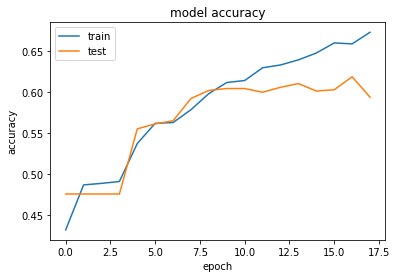

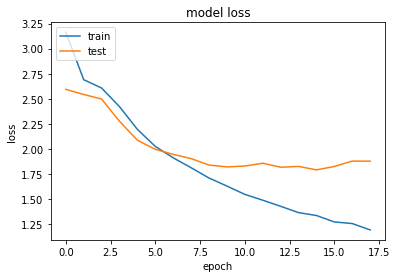

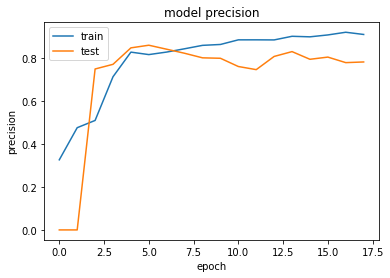

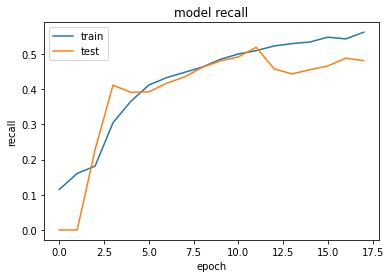

In [0]:
from matplotlib import pyplot as plt
try:
  plt.plot(history_HAN.history['accuracy'])
  plt.plot(history_HAN.history['val_accuracy'])
except:
  plt.plot(history_HAN.history['acc'])
  plt.plot(history_HAN.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_HAN.history['loss'])
plt.plot(history_HAN.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for mse
plt.plot(history_HAN.history['precision'])
plt.plot(history_HAN.history['val_precision'])
plt.title('model precision')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for mae
plt.plot(history_HAN.history['recall'])
plt.plot(history_HAN.history['val_recall'])
plt.title('model recall')
plt.ylabel('recall')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
# Test accuracy
accuracy = model_HAN.evaluate(X_test_HAN,Y_test_HAN)
print('Test Accuracy: %.2f%%' %(accuracy[1]*100))

1647/1647 [==============================] - 5s 3ms/step
Test Accuracy: 45.96%


In [0]:
# Saving this model
model_HAN.save("model_HAN.h5")
print("Saved model_HAN to disk")

Saved model_HAN to disk


### Best Model :- BiLSTM, 300D glove embeddings, upsampled dataset with 40376 records , Accuracy - 93.33%